In [48]:
import xgboost as xgb

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, mean_squared_error
from pandas.plotting import scatter_matrix
import pickle



In [67]:
nlp_df = pd.read_csv('../data/df_with_nlp.csv', index_col=0)
X = nlp_df
X = X.reindex(sorted(X.columns), axis=1)
y = pd.read_csv("../data/work-balance-stars.csv", header=None, index_col=0).values

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [66]:
X_train.columns

Index(['culture-values-stars', 'career-opportunities-stars',
       'comp-benefit-stars', 'senior-management-stars', 'helpful-count',
       'is_current_employee', 'year', 'quarter',
       'amazon_earnings_this_quarter', 'word_pro_work',
       ...
       'word_con_zu', 'word_con_sind', 'word_con_wenig', 'word_con_druck',
       'word_con_salair', 'word_con_vie', 'word_con_auch', 'word_con_schlecht',
       'word_con_von', 'timesteps'],
      dtype='object', length=4010)

### Random Forest

In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100, 200, 500, 1000],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)
print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 39.9min finished


best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}


In [27]:
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [28]:
y_pred = rf.predict(X_test)

In [33]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)

0.93692045248394


### Gradient Boosted Regressor

In [69]:
xgb_model = xgb.XGBRegressor(learning_rate=0.01, reg_lambda=1, n_estimators=500)
xgb_model.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [70]:
y_pred = xgb_model.predict(X_test)

In [71]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

1.2500822440984027
1.5627056170100984


In [79]:
X_train.columns[12:20]

Index(['word_con_11', 'word_con_12', 'word_con_14', 'word_con_15',
       'word_con_20', 'word_con_24', 'word_con_25', 'word_con_30'],
      dtype='object')

In [73]:
for i in range(len(y_test)):
    print(y_test[i], y_pred[i])

[5.] 3.411083
[1.] 3.0827537
[2.] 2.7072573
[3.] 3.090133
[3.] 2.8341615
[5.] 3.090133
[2.] 3.3107867
[4.] 2.8143976
[5.] 2.976563
[4.] 2.8341615
[4.] 2.985487
[1.] 3.090133
[4.] 2.9780302
[2.] 2.9964771
[2.] 2.7072573
[4.] 2.9084668
[5.] 2.9651306
[3.01421128] 2.7072573
[3.] 2.985487
[2.] 2.985487
[1.] 3.0001225
[2.] 3.090133
[4.] 3.3233557
[4.] 2.7072573
[5.] 2.986889
[3.] 2.985487
[5.] 3.199039
[5.] 2.9113097
[3.] 2.70579
[2.] 2.7198267
[4.] 3.3107867
[1.] 3.0827537
[2.] 2.8341615
[3.] 3.3107867
[1.] 2.9894068
[5.] 2.8341615
[3.] 3.090133
[3.] 2.9651306
[3.] 2.976563
[3.] 3.3107214
[3.] 2.8867743
[3.] 2.9651306
[4.] 3.090133
[4.] 2.9762323
[2.] 2.7072573
[5.] 2.998056
[2.] 3.090133
[2.] 2.7434216
[3.] 3.0040746
[2.] 2.9651306
[3.] 3.296895
[3.] 2.9651306
[2.] 3.1700664
[5.] 3.3107867
[5.] 3.084221
[1.] 3.090133
[1.] 2.985487
[5.] 2.9354248
[3.] 3.090133
[1.] 2.9780302
[2.] 2.9651306
[4.] 3.1407378
[5.] 3.0899417
[3.] 2.8341615
[4.] 2.8341615
[3.] 2.9780302
[4.] 2.7749717
[5.] 2.8341

[5.] 2.9890208
[1.] 3.0886657
[4.] 3.3107867
[3.] 3.3107867
[2.] 3.1328807
[4.] 2.70579
[1.] 3.1715233
[1.] 2.9651306
[2.] 3.090133
[1.] 3.3107867
[5.] 3.090133
[5.] 2.8326943
[3.] 3.2072334
[3.] 2.976563
[5.] 2.691387
[4.] 3.1441615
[3.] 3.3107867
[2.] 2.9084668
[4.] 2.9780302
[1.] 2.9651306
[3.] 3.3107867
[3.] 3.1364653
[3.] 2.8867743
[3.01421128] 2.885307
[1.] 2.8283677
[1.] 3.3048747
[3.01421128] 2.9905992
[5.] 3.3034074
[3.01421128] 2.885307
[2.] 2.885307
[1.] 3.090133
[1.] 2.8867743
[4.] 2.8867743
[3.] 3.0900676
[3.01421128] 3.090133
[4.] 2.839312
[2.] 3.3107867
[2.] 2.9651306
[3.] 2.825529
[1.] 2.9651306
[1.] 3.0532622
[3.] 3.3093195
[3.] 3.0040746
[4.] 3.3107867
[5.] 2.998056
[4.] 3.202089
[2.] 2.7578626
[2.] 2.7273088
[4.] 3.1012347
[3.] 3.3107867
[1.] 2.9780302
[3.01421128] 3.3233557
[4.] 2.976563
[3.01421128] 2.9651306
[5.] 2.885307
[2.] 2.7013452
[1.] 3.045883
[4.] 3.020778
[3.01421128] 2.7072573
[5.] 3.3107867
[1.] 2.9894068
[5.] 3.3093195
[4.] 3.00854
[3.01421128] 3.17005

[3.01421128] 3.090133
[3.01421128] 3.3020527
[3.01421128] 2.885307
[5.] 2.984648
[3.01421128] 2.8867743
[2.] 3.0886657
[4.] 3.090133
[3.] 2.8762877
[4.] 3.3093195
[1.] 2.9592185
[1.] 2.985487
[1.] 3.090133
[5.] 3.3107867
[1.] 2.8867743
[4.] 3.102702
[4.] 2.985487
[3.] 2.9084668
[1.] 3.090133
[3.01421128] 3.090133
[5.] 3.090133
[3.] 2.7013452
[4.] 3.3093195
[3.] 3.090133
[1.] 2.70579
[4.] 2.9964771
[3.] 2.8003614
[4.] 2.886695
[5.] 3.0536077
[5.] 2.9084668
[1.] 2.7013452
[4.] 3.5204263
[3.01421128] 3.0886657
[4.] 3.296895
[1.] 2.7072573
[1.] 2.9084668
[3.] 3.0886657
[4.] 2.9084668
[4.] 3.090133
[4.] 3.090133
[4.] 3.3079967
[3.01421128] 2.8341615
[2.] 2.7072573
[3.] 3.0532622
[3.01421128] 3.3107867
[3.01421128] 2.827081
[3.] 2.8593569
[5.] 2.9084668
[3.] 3.1715233
[2.] 2.805508
[3.01421128] 2.8018286
[5.] 2.8282313
[3.5] 2.9780302
[4.] 2.9651306
[3.] 2.8032305
[2.] 3.3773842
[3.] 3.3107867
[4.] 3.3107867
[2.] 2.985487
[3.] 2.7072573
[5.] 3.3233557
[4.] 3.3093195
[3.01421128] 2.78122
[5.]

[1.] 3.3107867
[4.] 3.170056
[4.] 2.70579
[4.] 2.7072573
[4.] 3.170056
[1.] 3.2704146
[1.] 3.3048747
[2.] 2.9084668
[5.] 3.3613915
[4.] 2.70579
[3.01421128] 2.9905992
[3.] 2.70579
[5.] 3.090133
[1.] 3.3218884
[3.] 2.8916936
[3.] 2.985487
[3.01421128] 2.8180768
[4.] 3.263959
[2.] 2.8845432
[1.] 2.805508
[4.] 2.998056
[5.] 2.7013452
[2.] 3.090133
[3.] 3.0191574
[5.] 2.9651306
[2.] 2.9651306
[5.] 2.8867743
[4.] 3.090133
[3.] 3.090133
[3.] 2.9592185
[2.] 2.9795754
[5.] 3.0886657
[5.] 3.090133
[2.] 2.6723695
[2.] 2.954074
[3.01421128] 3.090133
[1.] 3.3107867
[5.] 2.8867743
[5.] 3.0886657
[1.] 2.8575146
[5.] 2.9069996
[4.] 2.7054496
[2.] 2.7991035
[1.] 3.3107867
[1.] 2.7072573
[1.] 2.7183595
[1.] 2.879438
[3.] 2.8341615
[1.] 2.9890208
[3.] 2.9761212
[1.] 2.7072573
[3.01421128] 2.9207814
[2.] 2.6362817
[1.] 2.805508
[5.] 3.0886657
[4.] 2.7198267
[3.] 3.090133
[1.] 3.00854
[3.] 2.985487
[1.] 3.090133
[3.] 3.044713
[3.] 2.8867743
[3.01421128] 3.3107867
[5.] 2.9084668
[2.] 2.8018286
[3.] 3.09013

[3.] 2.7072573
[1.] 2.9780302
[1.] 2.8003614
[3.01421128] 3.3048747
[4.] 2.805508
[4.] 3.0466733
[3.] 3.3174045
[4.] 2.7072573
[3.] 2.976563
[5.] 3.3107867
[4.5] 2.9636633
[4.] 2.9025552
[4.] 3.296895
[5.] 3.090133
[4.] 2.985487
[5.] 3.3093195
[5.] 2.9592185
[2.] 3.0886657
[3.] 2.985487
[2.] 2.8341615
[4.] 3.3107867
[1.] 3.0075788
[1.] 2.976563
[1.] 3.1715233
[1.] 2.8467305
[4.] 2.847595
[1.] 2.9780302
[4.] 3.1012347
[3.] 3.1715233
[2.] 3.090133
[4.] 2.7072573
[4.5] 2.9780302
[1.] 3.090133
[2.] 2.7013452
[5.] 3.1715233
[3.] 2.976563
[3.] 2.8044627
[3.] 3.0886657
[5.] 2.8867743
[1.] 3.090133
[3.] 2.7916274
[3.] 2.750005
[3.] 3.0886657
[4.] 2.985487
[3.01421128] 3.090133
[3.01421128] 2.70579
[2.] 2.9651306
[4.] 2.7155752
[1.] 3.1185966
[4.] 3.3107867
[2.] 2.7124474
[1.] 2.985487
[1.] 2.9651306
[1.] 2.8467305
[1.] 2.9651306
[2.] 3.090133
[3.] 3.0767322
[3.] 2.8933926
[5.] 2.8032305
[4.] 3.3107867
[3.01421128] 2.985487
[5.] 3.103522
[3.] 2.9840198
[2.] 2.9974535
[1.] 3.054309
[3.01421128] 

[2.] 2.713875
[5.] 3.0174017
[2.] 2.70579
[3.] 2.911393
[3.] 2.985487
[2.] 2.9780302
[5.] 2.8180768
[3.01421128] 2.8452632
[4.] 2.9651306
[3.] 2.8180768
[4.] 2.7072573
[3.] 3.296895
[1.] 3.102702
[5.] 3.1715233
[1.] 2.8435438
[5.] 2.70579
[3.] 3.090133
[3.] 2.9780302
[4.] 2.9886901
[4.] 3.102702
[4.] 2.985487
[3.] 2.8341615
[4.] 2.9069996
[1.] 2.9788647
[4.] 3.3174045
[2.] 2.7972908
[1.] 2.805508
[3.] 3.2968297
[4.] 2.8867743
[2.] 3.1715233
[1.] 2.9651306
[1.] 2.9878614
[5.] 3.1056507
[3.] 2.9780302
[4.] 3.3218884
[5.] 3.0886657
[4.] 2.9780302
[2.] 2.8398645
[1.] 2.7072573
[3.] 2.8180768
[5.] 2.9489622
[3.] 3.1041834
[4.] 3.3107867
[1.] 2.9840198
[5.] 3.3233557
[1.] 2.9084668
[4.] 2.9070542
[3.] 2.9840198
[3.01421128] 3.090133
[1.] 3.3430939
[2.] 2.6804545
[5.] 3.3107867
[5.] 2.8867743
[2.] 2.7072573
[5.] 2.8180768
[4.] 3.1176486
[3.] 3.1620767
[3.] 3.090133
[4.] 2.7072573
[4.] 2.7072573
[4.] 3.3174045
[3.] 3.016066
[3.01421128] 3.1012347
[4.] 2.9762323
[1.] 2.8279479
[3.01421128] 3.09

[1.] 2.9084668
[3.01421128] 3.170056
[2.] 2.7739346
[3.] 2.7183595
[5.] 2.9069996
[2.] 3.3107867
[1.] 3.090133
[2.] 3.090133
[5.] 3.3233557
[1.] 3.0886657
[4.] 2.9780302
[3.] 2.8341615
[1.] 3.060221
[5.] 3.3107867
[3.] 2.9890208
[3.01421128] 3.3107867
[2.] 2.9780302
[4.] 3.031128
[5.] 3.0967507
[5.] 3.1361778
[1.] 2.8040407
[4.] 2.9905992
[3.] 2.70579
[1.] 3.090133
[2.] 2.8867743
[4.] 2.9651306
[3.] 2.9780302
[5.] 3.235826
[5.] 3.0886657
[2.] 2.8341615
[5.] 2.985487
[1.] 2.8895576
[3.01421128] 2.8003614
[3.01421128] 2.7778723
[4.] 3.3233557
[3.] 2.7192235
[1.] 3.3734257
[2.] 3.047388
[1.5] 3.1411767
[4.] 3.090133
[2.] 2.9780302
[4.] 3.0827537
[4.] 2.976563
[4.] 3.084221
[3.01421128] 2.8867743
[2.] 2.8341615
[3.] 2.6689193
[5.] 3.3107867
[3.] 3.084221
[3.] 3.3233557
[3.01421128] 2.9084668
[3.] 2.8326943
[4.] 2.985487
[4.] 2.985487
[4.5] 2.6569693
[4.5] 2.8948236
[3.] 2.7183595
[4.] 2.9943776
[5.] 3.3107867
[3.] 2.985487
[3.01421128] 3.0967507
[3.] 3.0193107
[4.] 2.9780302
[5.] 3.4302855

[1.] 3.3034074
[2.] 3.182625
[4.] 3.16721
[1.] 2.985487
[3.01421128] 2.805508
[3.] 2.8867743
[4.] 2.9840198
[2.] 3.090133
[2.] 2.8166096
[3.] 2.9780302
[4.] 3.3218884
[3.] 3.1374629
[3.] 2.8867743
[3.] 3.3218884
[4.] 3.3093195
[5.] 3.090133
[1.] 2.9124355
[2.] 2.70579
[1.] 3.3218884
[3.01421128] 3.090133
[3.] 3.1026366
[3.] 2.7198267
[1.] 2.7072573
[5.] 3.3107867
[3.01421128] 3.3048747
[2.] 2.7072573
[3.] 2.7072573
[3.5] 2.9780302
[3.] 2.985487
[2.] 2.9905992
[3.] 3.3107867
[1.] 2.9084668
[5.] 3.3107867
[1.] 2.976563
[3.] 2.8069098
[5.] 3.3107867
[2.] 3.3048747
[2.] 3.090133
[2.] 2.9651306
[4.] 3.090133
[4.] 3.0100071
[2.5] 2.9780302
[1.] 2.7072573
[5.] 3.3233557
[4.] 2.9084668
[3.01421128] 2.9098687
[2.] 2.9780302
[4.] 2.8040407
[5.] 3.090133
[5.] 3.1715233
[1.] 3.3107867
[3.] 2.6723695
[2.] 2.9905992
[5.] 2.7452931
[3.01421128] 3.0886657
[5.] 3.0886657
[1.] 2.70579
[3.5] 2.9780302
[5.] 3.3107867
[3.] 3.090133
[3.] 3.090133
[3.01421128] 3.090133
[3.] 2.9069996
[2.] 3.3107867
[4.] 2.98

[3.01421128] 2.985487
[5.] 3.1715233
[5.] 3.1041834
[2.] 2.713875
[1.] 2.8341615
[3.] 2.8040407
[4.] 3.090133
[1.] 2.7995958
[4.] 2.9780302
[5.] 2.8326943
[3.01421128] 2.9084668
[3.01421128] 2.9837315
[2.] 2.985487
[3.] 3.0421484
[5.] 2.905587
[4.] 2.8808627
[3.01421128] 2.70579
[1.] 2.805508
[4.] 2.7072573
[1.] 3.1715233
[3.01421128] 3.0967507
[3.] 2.7072573
[4.] 3.3093195
[3.] 3.3034074
[4.] 2.9964771
[2.] 3.3107867
[5.] 2.976563
[1.] 2.7072573
[5.] 2.9964771
[2.] 2.7072573
[4.] 2.8341615
[4.] 3.0886657
[5.] 3.0886657
[3.] 3.0827537
[3.01421128] 2.8341615
[3.] 2.984648
[4.] 2.9780302
[1.] 2.9651306
[2.] 2.9721181
[1.] 2.977173
[3.] 3.3107867
[3.] 2.8867743
[3.] 3.3107867
[4.] 3.090133
[2.] 2.8084464
[3.] 3.3093195
[5.] 3.3107867
[5.] 3.1715233
[3.] 2.9964771
[3.01421128] 2.7072573
[4.5] 2.9721181
[4.] 3.1056507
[4.] 3.1012347
[2.] 2.9780302
[3.01421128] 2.897876
[5.] 3.4131389
[3.01421128] 3.3048747
[3.] 2.9651306
[5.] 3.3107867
[3.] 3.090133
[2.] 3.102702
[4.] 2.9890208
[3.] 2.98548

[5.] 3.3107867
[2.] 2.9651306
[2.] 2.9636633
[1.] 2.9840198
[4.] 2.9651306
[2.] 2.9780302
[4.] 3.1012347
[3.01421128] 3.090133
[4.] 2.985487
[5.] 2.985487
[4.5] 2.9890208
[2.] 3.090133
[1.5] 3.0001225
[2.] 2.985487
[4.] 2.9780302
[3.01421128] 3.3093195
[1.] 3.3107867
[3.] 2.6115015
[2.] 3.2654262
[3.01421128] 3.3535345
[4.] 3.3107867
[2.] 3.3107867
[1.] 2.9069996
[2.] 3.0915349
[3.] 2.8867743
[5.] 2.9069996
[1.] 2.9921052
[1.] 2.9780302
[4.] 3.3107867
[5.] 3.3107867
[1.] 2.7072573
[5.] 3.1281688
[2.] 2.8210154
[2.] 2.7072573
[2.] 2.7197614
[3.] 3.090133
[3.] 2.9964771
[2.] 3.0176902
[2.] 2.7072573
[4.] 2.9964771
[4.] 2.805508
[4.] 3.3107867
[3.] 2.9651306
[4.] 3.1328807
[4.] 2.9279916
[1.] 3.090133
[2.] 2.9084668
[3.01421128] 2.8867743
[3.] 2.9513195
[3.01421128] 2.70579
[3.] 3.3010643
[3.] 3.0886657
[3.] 2.9840198
[1.] 3.0648034
[4.] 3.0886657
[4.] 3.0900676
[3.01421128] 2.985487
[1.] 2.7930193
[4.] 3.3107867
[3.] 2.702688
[3.] 3.055075
[3.] 2.7198267
[4.] 2.998056
[2.] 2.9780302
[4.]

[5.] 2.8157988
[5.] 3.3107867
[2.] 3.1364653
[1.] 3.0075908
[3.] 3.090133
[3.01421128] 3.090133
[5.] 2.9210358
[3.] 3.1715233
[4.] 2.70579
[1.] 2.9905992
[5.] 3.322753
[4.] 3.090133
[3.] 2.8993433
[1.] 3.3107867
[3.] 3.3107867
[3.] 2.7578626
[4.] 2.976563
[1.] 2.7072573
[1.] 2.805508
[4.] 3.0886657
[4.] 2.8341615
[2.] 2.885307
[5.] 2.985487
[5.] 3.0886657
[1.] 2.7281907
[4.] 2.9651306
[3.01421128] 2.8018286
[4.] 2.9592185
[4.] 3.3107867
[3.] 2.8040407
[1.] 3.1715233
[5.] 3.0954494
[2.] 2.9069996
[3.01421128] 2.9721181
[3.] 2.7072573
[4.] 2.8786957
[4.] 2.9840198
[3.] 2.9651306
[3.] 2.7995958
[4.] 2.8867743
[2.] 3.1722295
[3.01421128] 2.9905992
[3.] 2.9084668
[3.] 2.8867743
[5.] 3.102702
[1.] 3.3034074
[3.01421128] 2.7072573
[1.] 2.7197614
[2.] 2.70579
[5.] 2.8018286
[1.] 3.090133
[5.] 3.102702
[3.] 3.2482166
[2.] 3.3093195
[3.] 2.9780302
[3.01421128] 2.703249
[4.] 3.3648152
[4.] 2.985487
[1.] 3.0915349
[3.] 3.102702
[4.] 2.9651306
[3.] 2.8180768
[5.] 3.3107867
[3.] 3.170056
[1.] 2.8003

[3.01421128] 2.8341615


In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

0.8723116190562487
0.7609275607405339


In [72]:
with open('models/gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(xgb_model, f)

In [6]:
param_grid = {'max_depth': [3],
              'learning_rate': [0.01],
              'n_estimators': [100, 200, 500, 1000],
              'subsample': [0.5]
              }

gbr_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                             param_grid,
                             n_jobs=-1,
                             verbose=1,
                             scoring='neg_mean_squared_error',
                             cv=3)
gbr_gridsearch.fit(X_train, y_train)
print( "best parameters:", gbr_gridsearch.best_params_ )

best_gbr_model = gbr_gridsearch.best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.3min finished


best parameters: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [32]:
best_y_preds = best_gbr_model.predict(X_test)

In [23]:
for i in range(len(y_test)):
    print(y_test[i], best_y_preds[i])

NameError: name 'best_y_preds' is not defined

In [11]:
mse = mean_squared_error(y_test, best_y_preds)
rmse = mse ** 0.5
print(mse)
print(rmse)

1.8738464762673295
1.368885121647295


In [33]:
with open('models/best_gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(best_gbr_model, f)

In [73]:
y_pred = gbr.predict(X_test)

In [75]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(mse)
print(rmse)

0.8921436054582954
0.9445335385566229


### RNN

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint

In [16]:
timesteps=1

In [24]:
X_train = X_train[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]
X_test = X_test[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]

In [17]:
X_train = X_train.values.reshape(X_train.values.shape[0], timesteps, X_train.values.shape[1])
X_test = X_test.values.reshape(X_test.values.shape[0], timesteps, X_test.values.shape[1])

In [47]:
neurons=50
model = Sequential()
model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=5, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

In [42]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(32, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dropout(0.2))
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_23 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [43]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [44]:
NN_model.fit(X_train, y_train, epochs=5, batch_size=32, 
             validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=callbacks_list)

Train on 17706 samples, validate on 8722 samples
Epoch 1/5
 - 455s - loss: 1.8388 - mean_squared_error: 1.8388 - val_loss: 1.6091 - val_mean_squared_error: 1.6091

Epoch 00001: val_loss improved from inf to 1.60909, saving model to Weights-001--1.60909.hdf5
Epoch 2/5
 - 425s - loss: 1.6324 - mean_squared_error: 1.6324 - val_loss: 1.6085 - val_mean_squared_error: 1.6085

Epoch 00002: val_loss improved from 1.60909 to 1.60849, saving model to Weights-002--1.60849.hdf5
Epoch 3/5
 - 430s - loss: 1.6280 - mean_squared_error: 1.6280 - val_loss: 1.6068 - val_mean_squared_error: 1.6068

Epoch 00003: val_loss improved from 1.60849 to 1.60680, saving model to Weights-003--1.60680.hdf5
Epoch 4/5
 - 417s - loss: 1.6252 - mean_squared_error: 1.6252 - val_loss: 1.6059 - val_mean_squared_error: 1.6059

Epoch 00004: val_loss improved from 1.60680 to 1.60593, saving model to Weights-004--1.60593.hdf5
Epoch 5/5
 - 499s - loss: 1.6227 - mean_squared_error: 1.6227 - val_loss: 1.6052 - val_mean_squared_err

In [45]:
y_pred_rnn = NN_model.predict(X_test)

In [37]:
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = mse_rnn ** 0.5
print(mse_rnn)
print(rmse_rnn)

1.602812636013981
1.2660223678963896


In [46]:
for i in range(len(y_test)):
    print(y_test[i], y_pred_rnn[i])

[5.] [3.0441027]
[1.] [3.0004203]
[2.] [2.9751554]
[3.] [3.0191267]
[3.] [2.9931169]
[5.] [2.9972882]
[2.] [3.0112665]
[4.] [3.0047555]
[5.] [2.9921126]
[4.] [2.997701]
[4.] [3.0177186]
[1.] [3.0326993]
[4.] [2.995985]
[2.] [3.0092943]
[2.] [2.9794383]
[4.] [3.0028987]
[5.] [3.0046394]
[3.01421128] [2.9820342]
[3.] [3.0137894]
[2.] [3.0102627]
[1.] [2.9938788]
[2.] [3.0033855]
[4.] [3.017643]
[4.] [2.9784462]
[5.] [3.0121455]
[3.] [3.0122547]
[5.] [3.071879]
[5.] [2.9876974]
[3.] [2.9721355]
[2.] [2.9799862]
[4.] [3.0085244]
[1.] [3.0227585]
[2.] [2.9977946]
[3.] [3.00873]
[1.] [3.0061698]
[5.] [2.9886422]
[3.] [3.0074677]
[3.] [3.0091634]
[3.] [2.9916823]
[3.] [3.0022666]
[3.] [2.9906006]
[3.] [3.0136688]
[4.] [3.0008621]
[4.] [3.0058684]
[2.] [2.9741156]
[5.] [3.0142462]
[2.] [3.0132627]
[2.] [3.0082142]
[3.] [3.0363703]
[2.] [3.0112066]
[3.] [3.0053973]
[3.] [3.0046253]
[2.] [3.0007634]
[5.] [3.00404]
[5.] [3.0047626]
[1.] [3.0154076]
[1.] [3.0108857]
[5.] [3.0101335]
[3.] [3.001402

[3.01421128] [2.9987774]
[3.01421128] [2.998078]
[3.01421128] [2.9797204]
[2.] [2.9782608]
[3.] [3.005476]
[1.] [2.9952815]
[1.] [3.0117168]
[3.] [2.974144]
[1.] [3.0086215]
[4.] [3.0136688]
[3.01421128] [2.979714]
[2.] [3.0086865]
[2.] [2.9750395]
[2.] [2.9716558]
[2.] [3.0059125]
[3.] [2.999667]
[5.] [3.0167546]
[3.01421128] [3.0039062]
[3.] [3.0007608]
[4.5] [3.0020876]
[1.] [2.9703228]
[2.] [3.0018973]
[4.] [2.9942672]
[5.] [2.985847]
[3.01421128] [3.069734]
[3.01421128] [3.0024614]
[2.] [2.9854903]
[1.] [2.985679]
[2.5] [2.9942534]
[5.] [3.017643]
[4.] [3.0121455]
[4.] [3.0025854]
[2.] [3.0118277]
[4.] [3.0149355]
[1.] [3.0106058]
[1.] [3.005049]
[3.] [3.0152555]
[1.] [2.9645243]
[3.] [3.0091834]
[1.] [3.0340376]
[3.] [2.9976194]
[4.] [3.0101829]
[1.] [3.0025735]
[4.] [3.038796]
[4.] [3.016295]
[2.] [3.0083795]
[1.] [3.0046048]
[3.] [2.9979095]
[3.] [2.9836988]
[1.] [3.0118277]
[5.] [3.0314212]
[2.] [2.99755]
[5.] [2.98904]
[2.] [3.013736]
[1.] [2.9762464]
[4.] [2.9823434]
[5.] [3

[5.] [3.0051436]
[2.] [2.9747648]
[4.] [3.0078666]
[2.] [2.9698029]
[2.] [2.998586]
[5.] [3.0126498]
[5.] [3.0112512]
[1.] [2.9692163]
[2.] [2.9764361]
[4.] [3.006844]
[3.] [2.9872007]
[3.01421128] [3.0068398]
[1.] [3.0069146]
[2.] [3.0302444]
[3.] [3.0015898]
[2.] [3.001357]
[1.] [3.0086079]
[3.] [3.009647]
[3.01421128] [2.994833]
[4.] [2.9760044]
[2.] [2.984525]
[5.] [3.0098898]
[2.] [3.0946622]
[4.] [3.0047555]
[4.] [3.0054302]
[3.] [3.0023994]
[3.] [3.0108454]
[5.] [3.0531895]
[2.] [2.986033]
[1.] [2.9727192]
[4.] [3.0307245]
[4.] [3.0218282]
[2.] [3.0080843]
[2.] [2.997847]
[1.] [3.0046253]
[3.01421128] [3.0065784]
[3.] [3.0036979]
[3.] [3.0081577]
[3.01421128] [3.0086079]
[1.] [3.0036364]
[2.] [2.9667463]
[3.] [3.0078616]
[4.] [3.0073164]
[3.] [3.0211234]
[2.] [2.9936619]
[4.] [3.0121708]
[3.5] [3.005049]
[3.01421128] [2.9788616]
[1.] [2.9941611]
[2.] [2.9994442]
[4.] [2.996536]
[3.01421128] [3.1227586]
[4.] [3.0032284]
[3.] [2.9832067]
[3.] [2.984808]
[3.01421128] [3.0370913]
[3

[3.] [2.9816215]
[5.] [2.9954038]
[3.] [3.0032284]
[5.] [3.002635]
[4.] [3.0081916]
[1.] [3.0102253]
[5.] [2.9984536]
[3.01421128] [3.0127048]
[3.] [3.0385046]
[1.] [3.0082889]
[5.] [2.9970996]
[5.] [2.9711535]
[4.] [3.017643]
[2.] [2.9699206]
[1.] [2.976757]
[2.] [3.0152555]
[4.] [3.1051183]
[4.] [3.0005264]
[4.] [3.0177186]
[3.] [3.0003202]
[3.01421128] [2.9996126]
[5.] [3.0005555]
[1.] [2.9787495]
[4.] [2.9918647]
[3.] [3.007382]
[1.] [3.008369]
[3.] [3.0162897]
[4.] [3.0097568]
[2.] [3.0095]
[5.] [3.011475]
[5.] [3.0062869]
[2.] [2.999668]
[4.] [2.9957247]
[5.] [2.997701]
[2.] [3.0086079]
[1.] [3.0121455]
[5.] [3.0063193]
[1.] [2.997302]
[4.] [3.017643]
[1.] [2.993912]
[3.01421128] [2.9758651]
[1.] [3.0005808]
[5.] [2.9990711]
[1.] [3.0162027]
[4.] [3.004516]
[2.] [3.0080554]
[4.] [2.988724]
[1.] [2.979714]
[3.] [3.0090535]
[3.] [2.9996448]
[1.] [3.005073]
[2.] [2.9915566]
[1.] [3.0116913]
[4.] [2.9991264]
[3.] [3.0082371]
[3.] [3.0283222]
[3.] [3.0121455]
[1.] [3.0012665]
[2.] [2.

[4.] [3.0136688]
[4.] [2.9863682]
[2.] [3.0061517]
[2.] [3.0152555]
[2.] [2.976139]
[3.] [3.0051436]
[3.] [3.0017161]
[4.] [3.0044556]
[3.01421128] [2.9897833]
[2.] [2.9823434]
[3.] [2.9989111]
[1.] [3.022322]
[5.] [3.0127048]
[4.] [2.9856782]
[5.] [3.0043283]
[1.] [2.9697773]
[2.] [3.0314474]
[5.] [3.0147812]
[4.] [3.007557]
[4.] [2.982533]
[4.] [3.0124457]
[4.] [3.0073013]
[5.] [2.9957757]
[2.] [3.0063658]
[3.] [3.0957663]
[3.01421128] [2.9773855]
[3.] [2.9951265]
[3.] [3.0008469]
[4.] [3.008331]
[5.] [2.9997005]
[4.] [3.00563]
[2.] [3.0087006]
[1.] [2.979714]
[3.] [3.0040123]
[3.] [2.9808803]
[5.] [2.9982622]
[2.] [3.0007608]
[5.] [2.9961653]
[4.] [3.0493875]
[4.] [2.992168]
[2.] [2.9940598]
[4.] [3.014276]
[3.] [3.0127048]
[3.01421128] [2.9878013]
[2.] [2.9932754]
[5.] [2.993393]
[3.] [3.111097]
[5.] [3.0008554]
[3.] [3.0086079]
[2.] [3.0145545]
[2.] [2.9877882]
[3.] [3.0007195]
[3.01421128] [2.9986734]
[5.] [3.0178568]
[3.01421128] [3.038547]
[3.01421128] [2.974514]
[3.] [3.013668

[2.] [3.0017745]
[3.01421128] [3.0082526]
[5.] [3.00314]
[4.] [3.017643]
[2.] [3.0046253]
[4.] [3.0063658]
[4.] [3.0032783]
[1.] [2.9989283]
[4.] [3.005049]
[5.] [3.0102627]
[3.01421128] [2.9994442]
[3.] [3.024638]
[3.] [2.9666357]
[4.] [2.9981534]
[2.5] [3.0127425]
[4.] [3.0037708]
[3.01421128] [2.9992821]
[5.] [3.007709]
[4.] [3.012067]
[4.] [3.007794]
[5.] [3.0330722]
[1.] [3.0108275]
[3.] [2.9985757]
[3.] [2.9952123]
[1.] [3.008702]
[3.] [3.0285587]
[1.] [3.0010085]
[2.] [3.0078785]
[5.] [3.0045784]
[2.] [2.9926362]
[2.] [2.995985]
[5.] [3.0690765]
[4.] [3.0040393]
[2.] [2.994886]
[3.] [3.0082498]
[4.] [2.9959984]
[3.] [3.0046394]
[5.] [3.0250235]
[4.] [3.0030131]
[1.] [3.0539873]
[1.] [2.9704885]
[1.] [3.0009542]
[1.] [3.0167546]
[2.] [2.986384]
[4.] [3.0136688]
[3.01421128] [3.0327482]
[3.01421128] [3.0086865]
[4.] [3.0863597]
[3.] [3.012067]
[3.01421128] [3.0138493]
[1.] [3.005363]
[3.] [2.9977005]
[4.] [2.9727156]
[4.] [3.0001354]
[1.] [2.9732614]
[5.] [2.9975615]
[2.] [2.97989

[2.] [3.0790071]
[2.] [3.021089]
[3.] [3.0002298]
[3.] [3.0099175]
[3.] [3.0099323]
[3.] [3.0922437]
[3.01421128] [2.9798918]
[4.] [3.0052335]
[3.] [2.997701]
[1.] [2.9989111]
[1.] [2.9892516]
[3.] [3.0021849]
[2.] [2.9989269]
[3.] [2.9954238]
[4.] [2.9968224]
[3.] [2.9974852]
[2.] [2.967929]
[3.] [3.041358]
[1.] [2.9807613]
[3.] [3.0103514]
[4.] [2.9769459]
[4.] [3.0256674]
[3.01421128] [3.0205343]
[4.] [3.0052207]
[3.] [2.9957619]
[4.] [2.9918394]
[2.] [2.9742262]
[5.] [3.0037265]
[2.] [2.9720416]
[3.] [3.00772]
[3.] [3.0168297]
[2.] [3.0046632]
[5.] [2.9974918]
[3.01421128] [2.9838035]
[4.] [3.0021484]
[3.] [2.9974918]
[4.] [2.9795225]
[3.] [3.0044255]
[1.] [3.0103683]
[5.] [3.0384424]
[1.] [3.0036626]
[5.] [2.9716558]
[3.] [3.0008557]
[3.] [3.0046577]
[4.] [3.0021484]
[4.] [3.001245]
[4.] [3.0086865]
[3.] [2.9912434]
[4.] [3.001022]
[1.] [3.0066876]
[4.] [3.0028033]
[2.] [2.9977589]
[1.] [2.9936042]
[3.] [2.9976752]
[4.] [2.989791]
[2.] [3.0390215]
[1.] [3.008194]
[1.] [3.0042694]


[4.] [3.0053449]
[1.] [3.0136755]
[3.01421128] [3.001357]
[4.] [3.0737696]
[3.] [2.9863842]
[5.] [3.0013974]
[2.] [2.985501]
[1.] [2.9796646]
[2.] [2.98063]
[4.] [2.982533]
[3.] [3.0080228]
[2.5] [2.9971368]
[4.] [3.0065546]
[3.] [2.9789183]
[2.] [3.001807]
[3.] [3.0143042]
[1.] [2.974347]
[3.01421128] [3.0059211]
[3.] [2.9968288]
[5.] [2.993756]
[3.] [2.9785812]
[2.] [2.9997408]
[3.01421128] [2.9727964]
[2.] [3.0092943]
[3.] [3.0215745]
[4.] [2.9973152]
[3.] [3.0062099]
[4.] [3.0054617]
[1.] [2.9791148]
[3.01421128] [2.9854903]
[2.] [2.979714]
[1.] [2.976757]
[1.] [3.0039687]
[2.] [3.0214107]
[3.01421128] [3.0304027]
[2.] [2.9812803]
[3.01421128] [2.992098]
[1.] [3.0026112]
[4.] [2.988058]
[5.] [2.995985]
[5.] [3.0063658]
[3.] [3.0141952]
[2.] [3.0122352]
[2.] [3.0086975]
[2.] [2.9942417]
[3.01421128] [2.9822452]
[2.] [2.9961889]
[3.01421128] [3.00169]
[4.] [3.0103605]
[3.] [2.9937541]
[4.] [3.0240803]
[4.] [2.9940329]
[5.] [3.0057337]
[2.] [3.017643]
[4.] [3.022217]
[2.] [3.0355313]


[2.] [3.0075788]
[3.] [2.964524]
[4.] [3.002577]
[4.] [3.0326993]
[4.] [2.9966388]
[4.] [3.001104]
[1.] [3.0032856]
[1.] [2.9969678]
[5.] [3.01569]
[3.] [2.9855838]
[4.] [2.9997597]
[2.] [2.9994442]
[3.] [3.0103977]
[3.] [3.0066876]
[5.] [2.9641585]
[1.] [2.967088]
[1.] [3.0027]
[3.5] [2.987583]
[3.] [3.0136688]
[3.01421128] [3.0043464]
[1.] [2.997701]
[5.] [3.0107484]
[2.] [2.9903102]
[3.] [2.9916813]
[5.] [2.9995985]
[2.5] [2.994396]
[3.5] [3.005049]
[1.] [3.009432]
[5.] [2.9752855]
[2.] [2.9791265]
[2.] [3.1099515]
[4.] [3.002977]
[2.] [3.0141952]
[3.] [3.0010633]
[4.] [3.0666842]
[2.] [3.014416]
[4.] [3.0121455]
[2.] [3.006154]
[3.01421128] [3.0136688]
[5.] [3.0087554]
[3.01421128] [3.010858]
[3.] [2.9988334]
[2.] [3.0102627]
[4.] [2.9969258]
[3.] [2.9994442]
[3.] [2.997113]
[4.] [3.0017214]
[2.] [3.007268]
[5.] [2.9998176]
[2.] [2.9758625]
[5.] [3.0532236]
[3.] [2.9931884]
[1.] [3.0241299]
[4.] [3.0581534]
[2.] [3.0268464]
[4.] [2.973256]
[3.01421128] [2.9683518]
[4.] [2.997701]
[

[4.] [3.006482]
[5.] [3.0047705]
[1.] [2.9808793]
[2.] [2.9663653]
[1.] [3.0011878]
[3.01421128] [3.0066116]
[3.] [3.0082932]
[3.] [2.9764361]
[1.] [2.98218]
[5.] [3.012067]
[3.01421128] [2.9968271]
[2.] [2.9789805]
[3.] [2.9798918]
[3.5] [2.9987757]
[3.] [3.0147812]
[2.] [2.999844]
[3.] [3.00106]
[1.] [3.0138423]
[5.] [3.0177631]
[1.] [2.9930277]
[3.] [3.0017781]
[5.] [2.9963448]
[2.] [2.9969845]
[2.] [3.0135155]
[2.] [3.0067403]
[4.] [3.0017107]
[4.] [3.018391]
[2.5] [2.9996502]
[1.] [2.9810693]
[5.] [3.0087962]
[4.] [3.007471]
[3.01421128] [3.011907]
[2.] [3.0045633]
[4.] [2.9896784]
[5.] [3.0006042]
[5.] [3.0599225]
[1.] [3.0007608]
[3.] [2.9672713]
[2.] [2.9986286]
[5.] [2.97608]
[3.01421128] [2.9981842]
[5.] [3.0022259]
[1.] [2.968384]
[3.5] [3.005049]
[5.] [3.0063658]
[3.] [3.0453448]
[3.] [2.998356]
[3.01421128] [3.0275578]
[3.] [3.0004268]
[2.] [2.997302]
[4.] [3.0127294]
[3.01421128] [3.064002]
[3.01421128] [3.006154]
[5.] [3.0331733]
[4.] [2.9916599]
[3.01421128] [3.0054617]

[3.01421128] [3.0119665]
[4.] [3.041445]
[4.] [3.0448136]
[4.] [2.9750395]
[3.] [2.9855838]
[5.] [2.9992208]
[2.] [2.9720201]
[3.] [3.03]
[3.] [3.0088549]
[2.] [2.9798918]
[3.01421128] [3.0010085]
[3.01421128] [2.979714]
[4.] [2.9842417]
[5.] [2.9858568]
[5.] [2.9820342]
[2.] [2.9970994]
[2.] [2.98875]
[3.] [3.0138423]
[1.] [3.0047808]
[3.] [3.0053973]
[3.] [3.0113006]
[4.] [3.0049634]
[2.] [2.9941761]
[2.] [3.0177186]
[3.01421128] [3.0147018]
[3.01421128] [2.980676]
[3.] [3.0077837]
[4.] [3.0603094]
[1.] [2.997701]
[3.01421128] [2.9868333]
[3.] [3.0118127]
[4.] [3.0059714]
[3.] [2.9717946]
[2.] [2.996783]
[4.] [2.986328]
[1.] [2.9751554]
[1.] [2.9794984]
[1.] [3.0087228]
[1.] [2.9791312]
[3.] [3.005785]
[5.] [3.0082376]
[3.] [2.978396]
[3.] [2.9914606]
[3.01421128] [3.0192766]
[3.01421128] [3.0106726]
[3.] [3.002707]
[4.] [3.0107276]
[5.] [2.983261]
[4.5] [3.005049]
[3.01421128] [3.0230227]
[4.] [2.9947376]
[2.] [3.0144358]
[3.] [2.9990687]
[1.] [2.9706316]
[4.] [3.0033846]
[5.] [3.00

[1.] [3.0161424]
[3.] [2.9993641]
[3.] [3.0005555]
[1.] [3.0001194]
[1.] [3.0038376]
[4.] [3.0065527]
[4.] [3.010581]
[3.01421128] [3.0139163]
[4.] [3.0137885]
[5.] [2.992304]
[1.] [2.977242]
[3.] [3.009541]
[3.01421128] [2.989839]
[5.] [3.0112731]
[1.] [3.0127711]
[5.] [2.9939532]
[2.] [3.0023966]
[4.] [3.0058572]
[2.] [3.0008264]
[1.] [2.97066]
[3.] [3.0012941]
[2.] [3.0112731]
[5.] [3.0784183]
[3.] [2.9957082]
[3.] [3.0000951]
[3.] [2.9979153]
[4.] [3.013051]
[2.] [2.971881]
[4.] [3.0103571]
[3.01421128] [3.0068486]
[4.] [3.00658]
[4.] [3.0132408]
[3.01421128] [2.9841444]
[5.] [3.031259]
[5.] [3.0086865]
[2.] [2.9855838]
[3.] [2.9717503]
[4.] [2.998545]
[3.] [2.9947395]
[5.] [2.9846182]
[2.] [3.001354]
[1.] [3.0059695]
[5.] [3.005363]
[4.] [2.999465]
[5.] [3.0548282]
[4.] [3.0033298]
[3.] [3.012067]
[2.] [2.9800608]
[3.] [3.0177183]
[3.] [2.9943614]
[3.01421128] [2.9937272]
[1.] [3.0138757]
[4.] [3.0107226]
[1.] [2.9726627]
[4.] [3.010015]
[1.] [2.9770498]
[3.] [3.030898]
[2.] [2.98

[1.] [2.993831]
[1.] [3.003834]
[3.] [3.0150225]
[3.01421128] [3.1012878]
[2.] [3.0117166]
[5.] [2.9757707]
[4.] [3.0466886]
[4.] [3.0177186]
[5.] [3.026032]
[1.] [2.9876435]
[1.] [2.970344]
[3.] [3.0288002]
[4.] [2.9770849]
[1.5] [2.9975615]
[5.] [2.9991825]
[1.] [2.9762583]
[3.] [3.0132208]
[2.] [3.0040958]
[1.] [2.9877448]
[2.] [3.0267482]
[5.] [3.0005598]
[3.] [2.99412]
[1.] [2.9908078]
[3.01421128] [3.0142245]
[1.] [2.9997597]
[4.] [3.0121455]
[3.] [2.9937727]
[3.01421128] [2.994643]
[4.] [2.9977946]
[1.] [2.984525]
[1.] [3.0032911]
[2.] [3.008194]
[3.] [3.0154767]
[5.] [3.0016613]
[3.01421128] [3.029392]
[3.] [3.048945]
[1.5] [3.008084]
[3.] [3.0033844]
[3.01421128] [3.0344486]
[3.] [3.0078077]
[3.01421128] [2.9867182]
[1.] [3.012067]
[4.] [3.0563796]
[3.01421128] [3.0029573]
[4.] [3.0041063]
[4.] [3.0080843]
[2.] [2.9994442]
[1.] [2.9979637]
[2.] [2.9836545]
[3.] [3.009274]
[5.] [3.0393443]
[5.] [3.0340047]
[3.01421128] [3.004859]
[1.] [2.9926536]
[2.] [3.0041616]
[4.] [2.994117

[3.] [3.017643]
[3.01421128] [2.9646435]
[5.] [3.000341]
[1.] [3.0077837]
[5.] [2.9967437]
[2.] [2.9647946]
[2.] [3.0144436]
[3.] [2.9996126]
[1.] [2.9847116]
[5.] [2.9830182]
[4.] [3.0077837]
[5.] [3.0004816]
[1.] [3.0012734]
[3.] [2.984334]
[5.] [2.9844487]
[4.] [2.9953663]
[4.] [2.9916248]
[2.] [3.0112658]
[3.01421128] [2.9951115]
[3.01421128] [3.014682]
[1.] [3.0084574]
[2.] [2.9739723]
[5.] [3.0064237]
[1.] [2.9755695]
[4.] [2.9787495]
[3.] [2.978207]
[2.] [3.004395]
[3.01421128] [3.0079205]
[4.] [2.9999528]
[3.01421128] [2.9906006]
[3.] [3.0177183]
[3.01421128] [2.9755683]
[4.] [3.0040565]
[4.] [2.9868333]
[1.5] [2.9962082]
[1.] [2.99436]
[2.] [2.9887528]
[4.] [3.0558715]
[4.] [3.0177186]
[5.] [3.103157]
[3.] [2.963953]
[4.] [2.9945211]
[2.] [2.9948268]
[3.01421128] [2.9942315]
[1.] [2.9888253]
[2.] [3.00974]
[1.] [2.9946697]
[2.] [3.0009694]
[5.] [2.992694]
[1.] [2.9967754]
[3.01421128] [3.0082376]
[3.] [2.9882228]
[5.] [3.0063658]
[4.] [2.987987]
[5.] [2.9857578]
[1.] [2.997273

In [56]:
with open('models/rnn_model.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(model, f)

In [53]:
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = mse_rnn ** 0.5
print(mse_rnn)
print(rmse_rnn)

1.6099188849161883
1.2688257898215138


### Later

In [ ]:
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
_ = scatter_matrix(amazon_df, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [ ]:


fig, ax = plt.subplots(figsize=(14, 3))

plot_univariate_smooth(
    ax, 
    non_zero_bal_df["limit"].values.reshape(-1, 1),
    non_zero_bal_df['balance'],
    bootstrap=100)

ax.set_title("Univariate Effect of Credit Limit on Non-zero Bank Balance")
ax.set_ylabel("Non-zero Balance")
ax.set_xlabel("Limit")

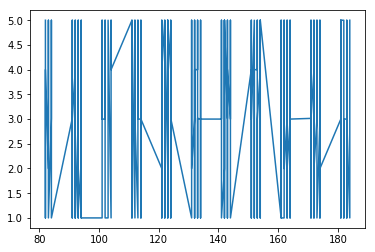

In [6]:
plt.plot(X['timesteps'], y)

In [ ]:
limit_fit = Pipeline([
    ('limit', ColumnSelector(name='limit')),
    ('limit_spline', LinearSpline(knots=[2500, 6000, 7000]))
])